# Higgs Boson challenge

# Exploratory data analysis - feature selection


This dataset has been built from official ATLAS full-detector simulation, with "Higgs to tautau" events mixed with different backgrounds. The task is to classify events into "tau tau decay of a Higgs boson" versus "background".


## Dataset characteristics

[Kaggle Challenge Page](https://www.kaggle.com/c/higgs-boson)

The dataset from Kaggle has 800000 events (195.5 MB in total):
- Training set of 250000 events
- Test set of 550000 events

Training set has 30 feature columns, a weight column and a label column.
Test set has 30 feature columns and a label column.


### Feature characteristics

- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by  the physicists of ATLAS
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables

### Class distribution

The class distribution of the training set is

- b (background) : 164333 events (66%)
- s (Higgs to tau tau):  85667 (34%)

We can see there is a class imbalance.

In [1]:
# Usual imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(9,6)})
plt.rcParams['figure.figsize'] = (9,6)

import IPython.display as ipd
pd.options.display.max_columns = 35

# random seed for reproducibility
np.random.seed(42)

In [2]:
df = pd.read_csv("data/training.csv",sep=',').astype({'Label': 'category'})
print("Raw training data:")
ipd.display(df.tail(10))

data = df.drop(['EventId', 'Label', 'Weight'], axis=1)
kaggle_weights = df['Weight']
# encode categorical class variable
target = df['Label']
# replace -990.0 values with NaNs
data = data.replace(-999.0, np.NaN)
weight = df['Weight']

Raw training data:


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249990,349990,127.822,82.865,100.024,0.860,-999.000,-999.000,-999.000,3.210,0.860,71.325,2.322,-1.321,-999.000,21.474,-0.640,1.618,49.852,1.391,-0.867,35.847,2.674,120.320,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,6.346934,b
249991,349991,133.457,77.540,88.989,69.650,-999.000,-999.000,-999.000,2.484,2.490,166.396,0.629,-0.084,-999.000,58.596,-0.834,-0.711,36.831,-1.172,1.749,41.870,-1.073,203.174,1,70.969,-1.234,2.521,-999.000,-999.000,-999.000,70.969,0.001502,s
249992,349992,-999.000,38.083,749.970,77.877,1.511,216.006,-0.513,4.351,44.689,583.680,0.275,-1.413,0.007,298.035,1.110,-0.023,82.076,-1.932,3.088,159.927,-2.861,652.616,3,91.581,-0.996,-3.109,76.222,0.515,0.416,203.569,0.744056,b
249993,349993,130.075,3.918,66.781,77.369,0.936,322.296,-0.207,3.102,49.937,610.482,1.354,-0.634,0.000,27.364,2.403,1.348,37.052,1.775,-1.689,67.702,-1.768,694.010,3,155.864,-0.358,1.093,134.344,0.578,-2.215,546.066,0.001503,s
249994,349994,217.020,47.156,62.824,127.953,0.295,119.437,-0.014,2.318,3.628,242.586,1.393,1.393,0.000,28.586,1.094,1.729,39.824,0.700,-0.555,97.737,0.220,271.082,2,141.752,0.237,3.126,32.423,-0.058,-1.137,174.176,0.064061,b
249995,349995,-999.000,71.989,36.548,5.042,-999.000,-999.000,-999.000,1.392,5.042,55.892,1.258,-1.414,-999.000,24.754,-0.414,-0.905,31.137,-0.950,0.380,46.520,2.859,144.665,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.000,-999.000,-999.000,2.585,22.439,50.618,1.162,-1.345,-999.000,23.416,-1.609,2.776,27.202,0.308,1.042,46.737,-0.867,80.408,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.000,-999.000,-999.000,2.390,22.183,120.462,1.202,0.529,-999.000,35.636,-0.266,-3.132,42.834,0.381,0.851,23.419,-2.890,198.907,1,41.992,1.800,-0.166,-999.000,-999.000,-999.000,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.000,-999.000,-999.000,3.365,13.504,55.859,0.999,1.414,-999.000,27.944,-2.211,2.792,27.915,-0.874,-0.296,12.150,0.811,112.718,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.000,-999.000,-999.000,2.025,7.479,83.240,0.936,-1.411,-999.000,43.003,1.685,2.653,40.236,1.490,0.637,40.729,-1.596,99.405,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.877474,b


In [3]:
# number of classes
ipd.display(target.value_counts())
ipd.display(data.describe())

b    164333
s     85667
Name: Label, dtype: int64

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,211886.000000,250000.000000,250000.000000,250000.000000,72543.000000,72543.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,72543.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,150087.000000,150087.000000,150087.000000,72543.000000,72543.000000,72543.000000,250000.000000
mean,121.858528,49.239819,81.181982,57.895962,2.403735,371.783360,-0.821688,2.373100,18.917332,158.432217,1.437609,-0.128305,0.458290,38.707419,-0.010973,-0.008171,46.660207,-0.019507,0.043543,41.717235,-0.010119,209.797178,0.979176,84.822105,-0.003275,-0.012393,57.679474,-0.011845,-0.001582,73.064591
std,57.298157,35.344886,40.828691,63.655682,1.742226,397.699325,3.584362,0.782911,22.273494,115.706115,0.844743,1.193585,0.398681,22.412081,1.214079,1.816763,22.064922,1.264982,1.816611,32.894693,1.812223,126.499506,0.977426,60.662276,1.784546,1.813385,31.985782,2.031743,1.816950,98.015662
min,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-18.066000,0.208000,0.000000,46.104000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.505000,-3.142000,0.109000,-3.142000,13.678000,0.000000,30.000000,-4.499000,-3.142000,30.000000,-4.500000,-3.142000,0.000000
25%,91.885250,19.241000,59.388750,14.068750,0.882500,111.977000,-2.629000,1.810000,2.841000,77.550000,0.883000,-1.371000,0.004000,24.591750,-0.925000,-1.575000,32.375000,-1.014000,-1.522000,21.398000,-1.575000,123.017500,0.000000,44.422500,-1.342000,-1.584000,37.312000,-1.612000,-1.576500,0.000000
50%,112.406000,46.524000,73.752000,38.467500,2.107000,225.885000,-0.244000,2.491500,12.315500,120.664500,1.280000,-0.356000,0.454000,31.804000,-0.023000,-0.033000,40.516000,-0.045000,0.086000,34.802000,-0.024000,179.739000,1.000000,65.561000,0.000000,-0.033000,47.902000,-0.010000,-0.002000,40.512500
75%,135.482000,73.598000,92.259000,79.169000,3.690000,478.226000,0.958000,2.961000,27.591000,200.478250,1.777000,1.225000,0.879000,45.017000,0.898000,1.565000,53.390000,0.959000,1.618000,51.895000,1.561000,263.379250,2.000000,103.342000,1.336000,1.562000,66.637000,1.589500,1.576000,109.933750
max,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,1852.462000,19.773000,1.414000,1.000000,764.408000,2.497000,3.142000,560.271000,2.503000,3.142000,2842.617000,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


## Missing values

-990.0 values represent entries that have no meaning/that could not be calculated. The figure below shows the the percentage of those missing values per column.

We can see than there are a lot of missing values: 72% of rows contain at least one missing value and  of some columns have up to 71% of them. So it is not viable to delete rows or columns, otherwise it will throw away too much data. Moreover the fact that a variable has no meaning or couldn't be calculated might be correlated with the label.

The three possibilities we have to solve the problem of missing data are:
- conserve -990.0 values: the value was chosen to be abnormal and distant from real data points; hence a model could be capable of identifying it and treat this value as missing.
- replace with NaN values and use algorithms that manage missing values (for example XGBOOST)
- impute those value swith the median (more robust than the man), this will smooth the data but may remove the explicative potential of those values.

Percentage of rows containing at least one missing value: 72.7544


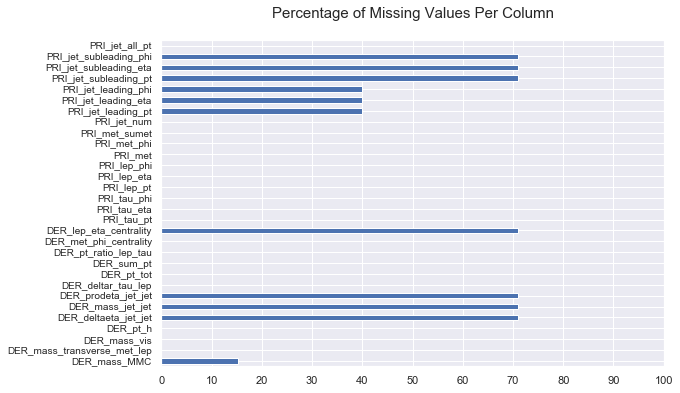

DER_mass_MMC                   15.2456
DER_mass_transverse_met_lep     0.0000
DER_mass_vis                    0.0000
DER_pt_h                        0.0000
DER_deltaeta_jet_jet           70.9828
DER_mass_jet_jet               70.9828
DER_prodeta_jet_jet            70.9828
DER_deltar_tau_lep              0.0000
DER_pt_tot                      0.0000
DER_sum_pt                      0.0000
DER_pt_ratio_lep_tau            0.0000
DER_met_phi_centrality          0.0000
DER_lep_eta_centrality         70.9828
PRI_tau_pt                      0.0000
PRI_tau_eta                     0.0000
PRI_tau_phi                     0.0000
PRI_lep_pt                      0.0000
PRI_lep_eta                     0.0000
PRI_lep_phi                     0.0000
PRI_met                         0.0000
PRI_met_phi                     0.0000
PRI_met_sumet                   0.0000
PRI_jet_num                     0.0000
PRI_jet_leading_pt             39.9652
PRI_jet_leading_eta            39.9652
PRI_jet_leading_phi      

In [4]:
# show percentage of nans per column
perc_nans = data.isna().sum() * 100 / len(data)
perc_rows_nans = (len(data) - len(data.dropna()))*100/(len(data))
print("Percentage of rows containing at least one missing value:", perc_rows_nans)
plt.figure(figsize=(9,6))
ax = perc_nans.plot.barh()
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))
ax.tick_params(axis='y', labelsize=10)
plt.title("Percentage of Missing Values Per Column\n", fontsize=15)
#plt.savefig("figures/Percentage_of_Missing_Values_Per_Column.eps", bbox_inches = "tight")
plt.show()

ipd.display(perc_nans)

## Histograms

To get a better understanding of the features distributions we plot the histograms for each features. 

Some variables seem to follow well known probability distributions:

- Gaussians (ex. `PRI_tau_eta`, `PRI_lep_eta`)
- Beta distribution with one parameter alpha (U distribution) (`DER_lep_eta_centrality`, `DER_met_phi_centrality`)
- Uniform distributions (ex. `PRI_tau_phi`, `PRI_met_phi`)
- Exponential distributions (ex. `DER_sum_pt`, `PRI_jet_leading_pt`)


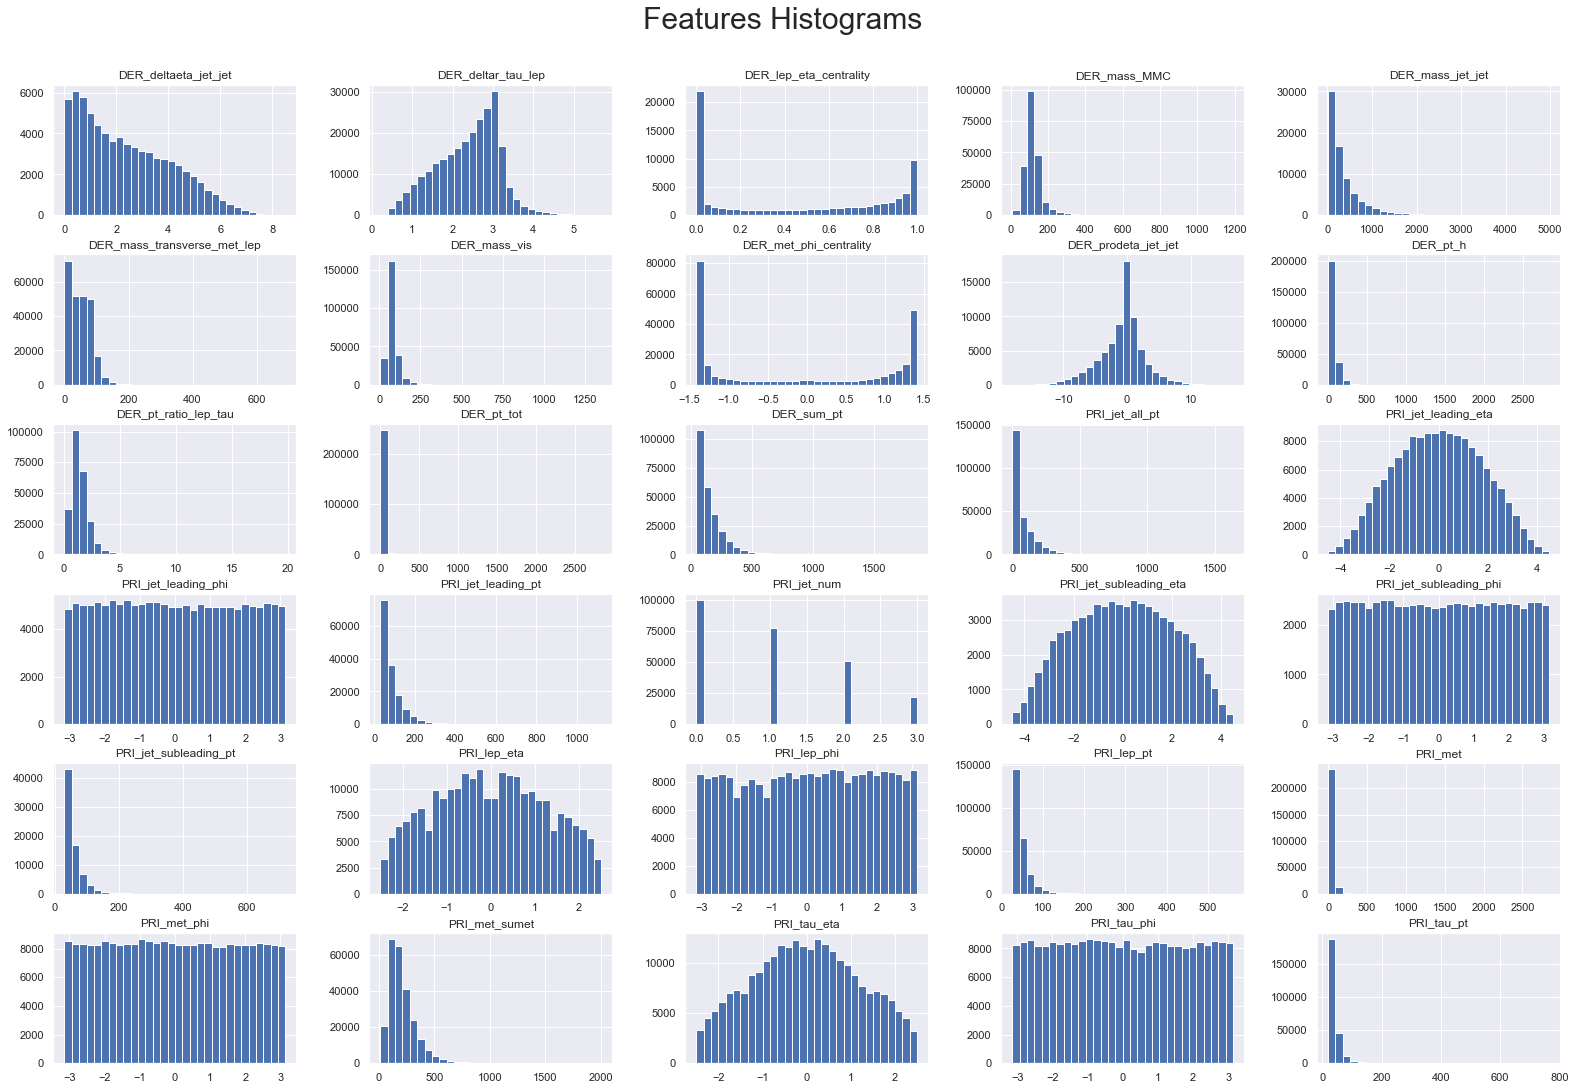

In [5]:
# show histograms of features
data.hist(bins=30, figsize=(27,18))
plt.suptitle("Features Histograms", fontsize=30, y=0.94)
#plt.savefig("figures/Histograms.svg")
plt.show()

## Per-class histograms for primitive features and derived features

Here, the features are separated into primitives (PRI) and derived (DER). For each feature we plot two histograms, one per class, to see any differences in distribution.

Certain features, for ex. `DER_mass_MMC` and `DER_mass_transverse_met_lep` have significative differences in their distributions between classes, they will probably be discriminant.

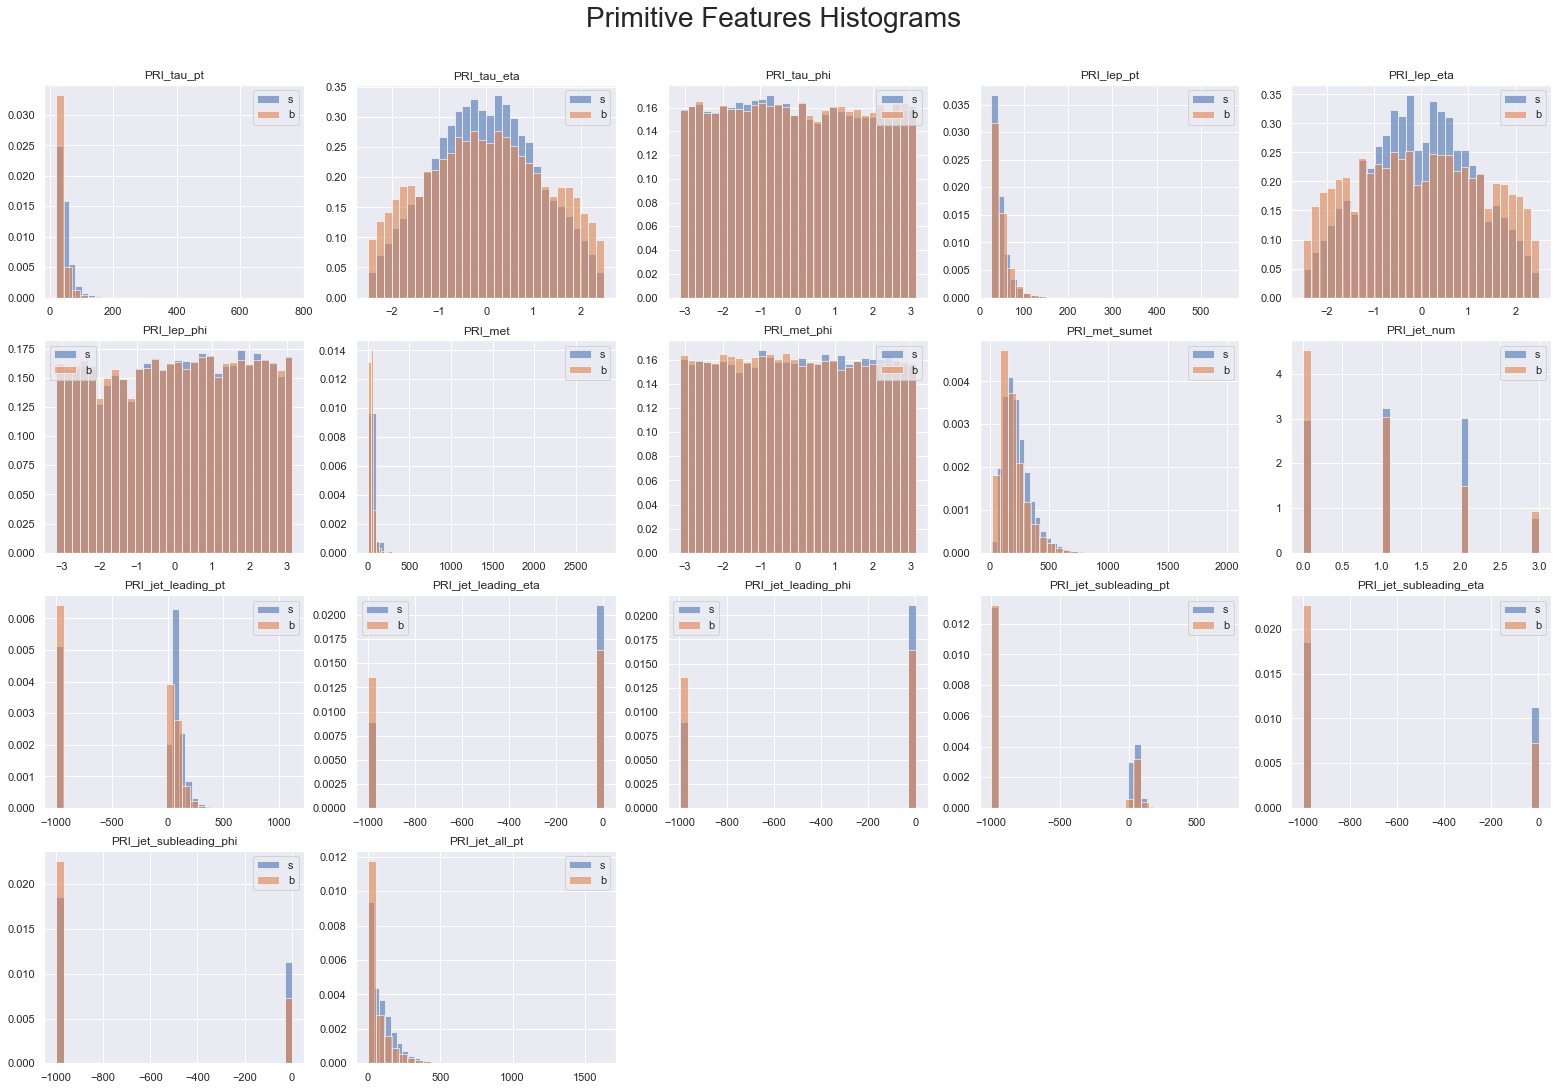

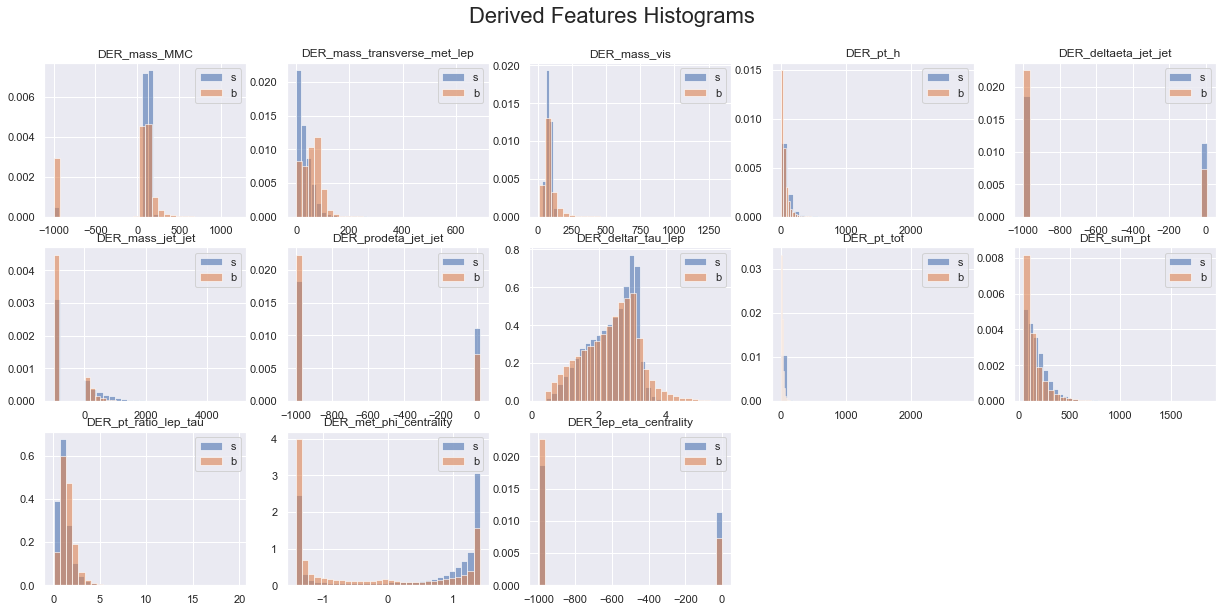

In [6]:
# show histograms of primitives features

pri = df.loc[:, df.columns.str.startswith(('PRI', 'Label'))]
pri_columns = pri.drop('Label', axis=1).columns

# show histograms of features
#data.hist(bins=30, figsize=(27,18))
#plt.show()

def sephist(df, col):
    s = df[df['Label'] == 's'][col]
    b = df[df['Label'] == 'b'][col]
    return s, b

plt.figure(figsize=(27, 18),)

for num, column in enumerate(pri_columns):
    plt.subplot(4, 5, num+1)
    sep = sephist(pri, column)
    plt.hist(sep[0], bins=30, density=True, alpha=0.6, label='s')
    plt.hist(sep[1], bins=30, density=True, alpha=0.6, label='b')
    plt.legend(loc='best')
    plt.title(column)

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.suptitle("Primitive Features Histograms", fontsize=28, y=0.94)
#plt.savefig("figures/Primitive_Features_Histograms.svg")
plt.show()

# show histograms of primitives features

der = df.loc[:, df.columns.str.startswith(('DER', 'Label'))]
der_columns = der.drop('Label', axis=1).columns

# show histograms of features
#data.hist(bins=30, figsize=(27,18))
#plt.show()

def sephist(df, col):
    s = df[df['Label'] == 's'][col]
    b = df[df['Label'] == 'b'][col]
    return s, b

plt.figure(figsize=(21, 13))

for num, column in enumerate(der_columns):
    plt.subplot(4, 5, num+1)
    sep = sephist(der, column)
    plt.hist(sep[0], bins=30, density=True, alpha=0.6, label='s')
    plt.hist(sep[1], bins=30, density=True, alpha=0.6, label='b')
    plt.legend(loc='best')
    plt.title(column)

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.suptitle("Derived Features Histograms", fontsize=22, y=0.94)
#plt.savefig("figures/Derived_Features_Histograms.svg")
plt.show()


## Correlations matrices

We compute the pairwise correlation of columns, excluding NaN values, with the Pearson's coefficient.  

We can observe that several variables are highly correlated (for example `DER_sum_pt` with `PRI_jet_all_pt` (0.97)). As some variables are derived from others this is expected. There are also high correlations between primitives variables (ex. `PRI_met_sumet` with `PRI_jet_all_pt` (0.88))

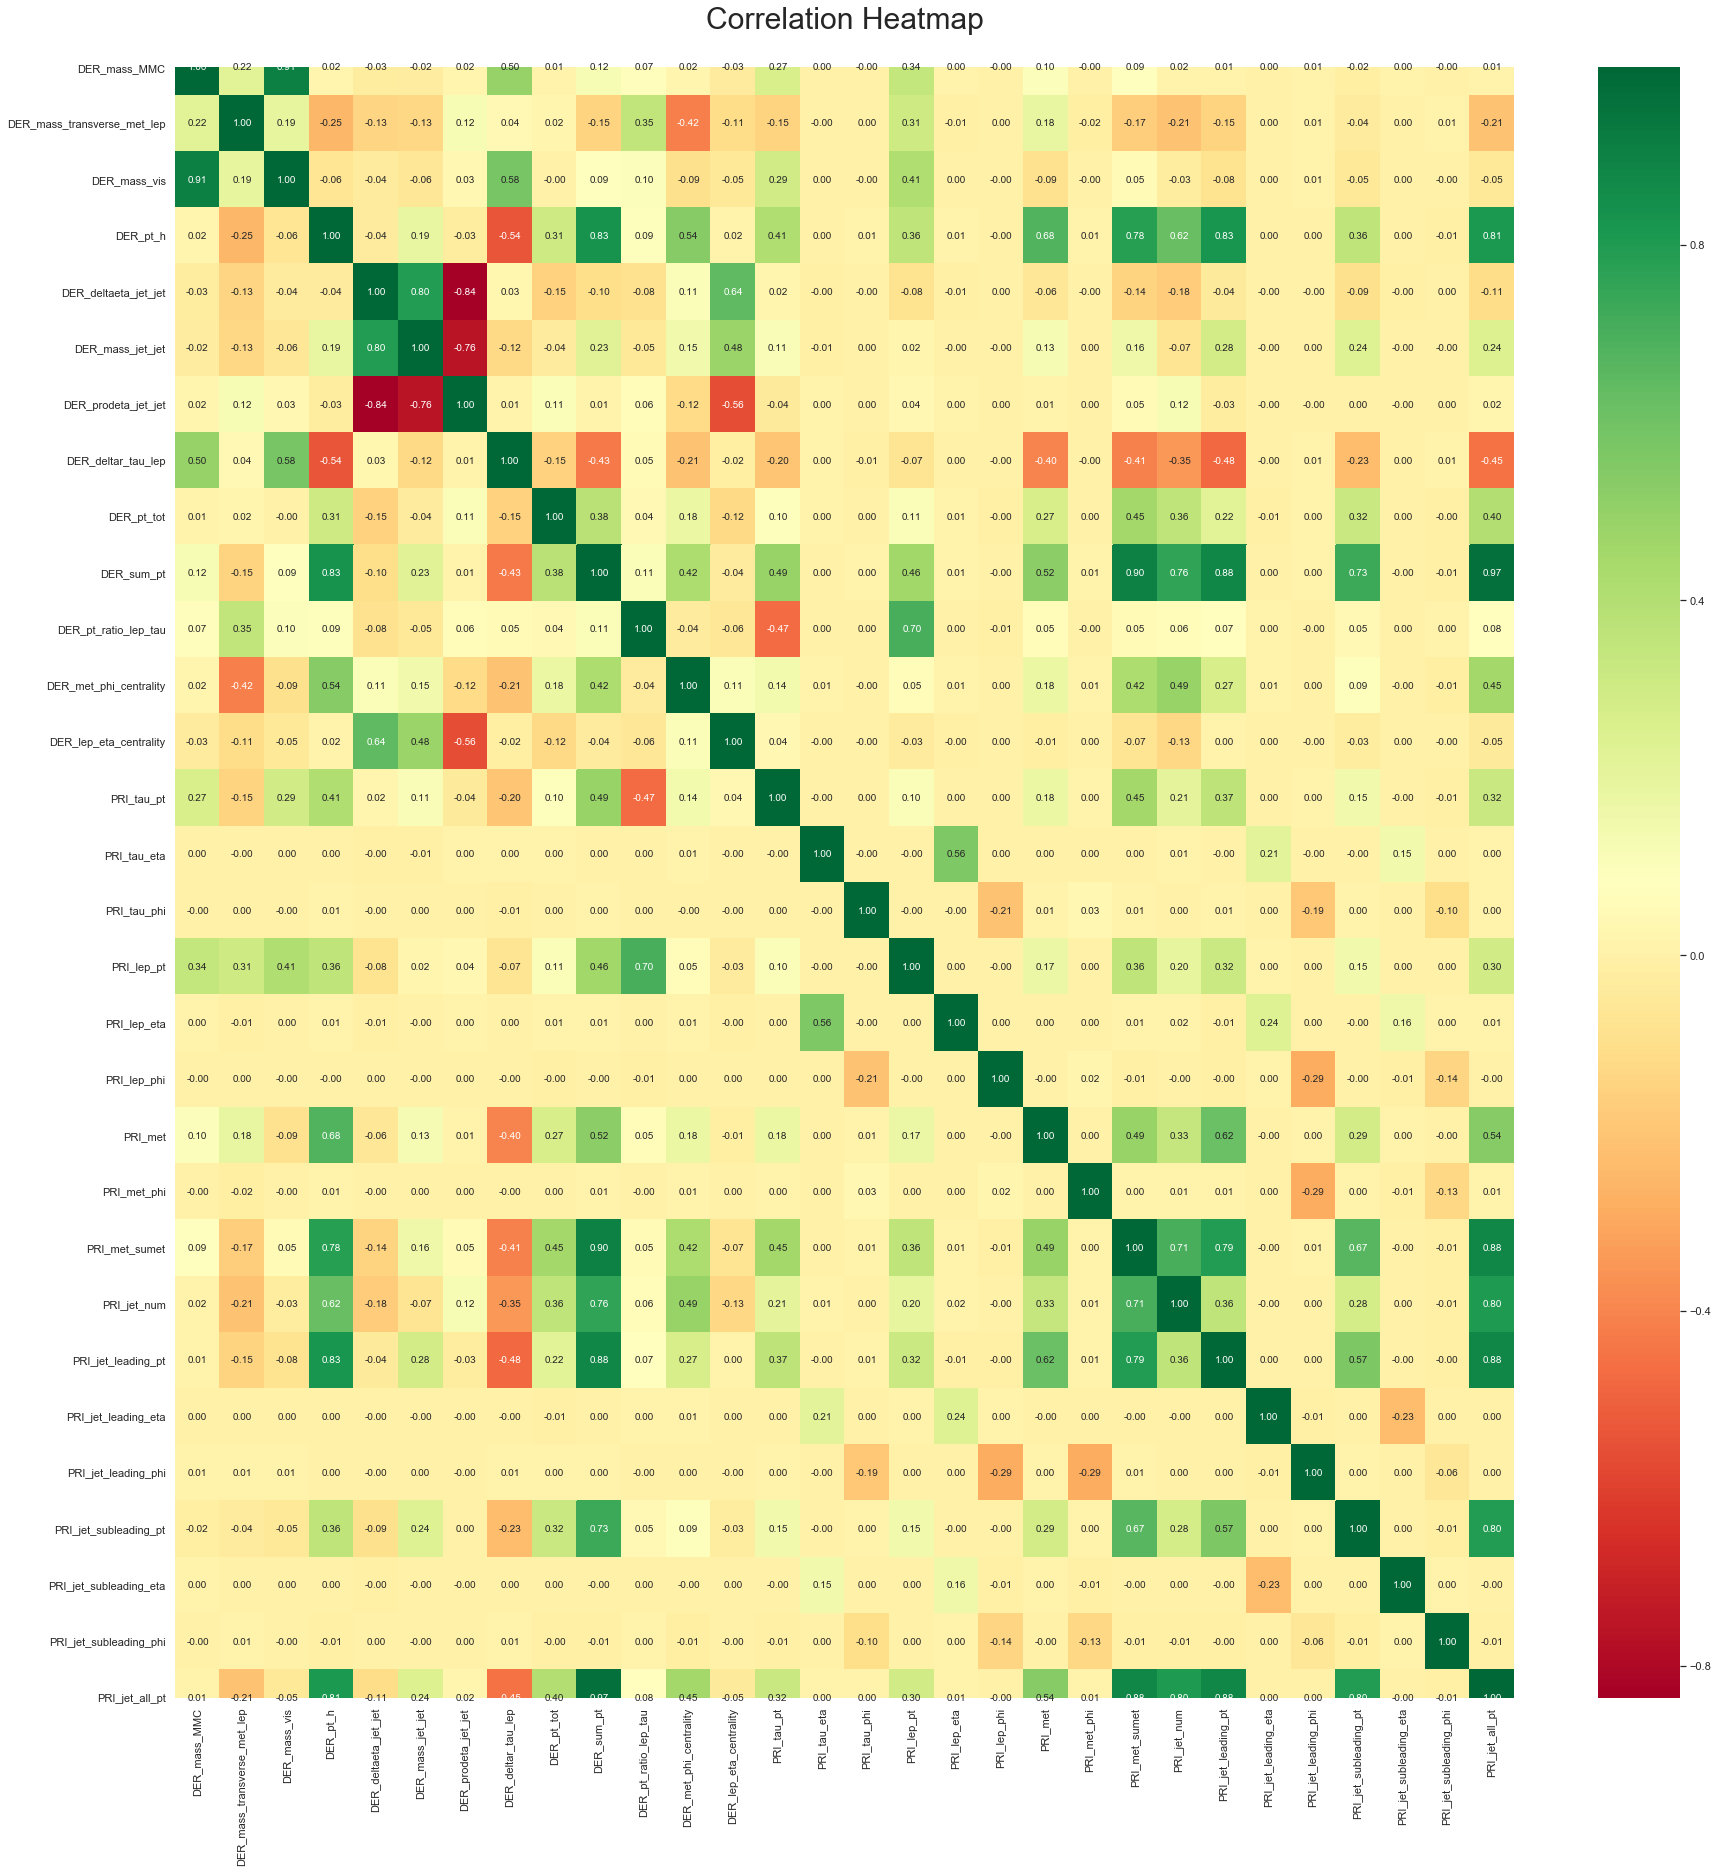

In [7]:
# Correlation matrix
corr = data.corr()
corr.index = data.columns
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Correlation Heatmap\n", fontsize=30)
plt.show()

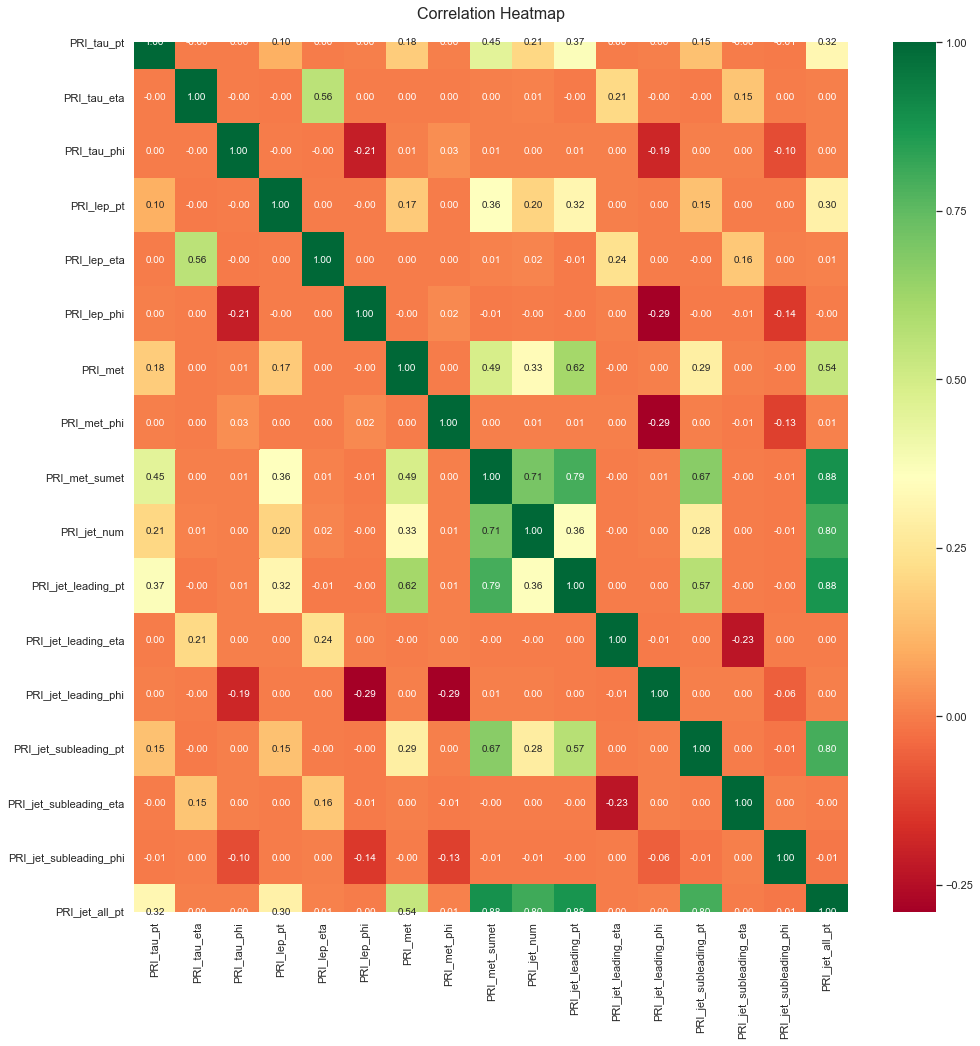

In [8]:
pri = pri_data = data.loc[:, data.columns.str.startswith('PRI')]

# Correlation matrix
pri_corr = pri_data.corr()
pri_corr.index = pri_data.columns
plt.figure(figsize=(16,16))
sns.heatmap(pri_corr, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Correlation Heatmap\n", fontsize=16)
plt.show()

## Analysis of the importance of features via a random forest classifier.

To get a grasp of feature importances for classification, the best method we see is an "a posteriori" selection from the learning of a classifier capable of assigning importance to each of the features.
We train a random forest with untuned hyperparams to get a scores of features importances.

For each decision tree, the importance of a feature importance is computed as the (normalized) total reduction of the Grini criterion brought by that feature. It is also known as the Gini importance. It follows that the importances of features for the random forest are the mean of those importances for each tree.

In [9]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
target_enc = le.transform(target)

#mi = mutual_info_regression(imp_data, target_enc)
#mi /= np.max(mi)

## Random Forest Classifier to visualize feature importances

By fitting classifier like a random forest on the data, we can observe the importance of features for the classification afterwards.

For each decision tree, the importance of a feature importance is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
It follows that the importances of features for the random forest are the mean of those importances for each tree. 

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

y = target.cat.codes
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(data.values)

clf = RandomForestClassifier(n_estimators=150, max_depth=10, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Feature ranking:


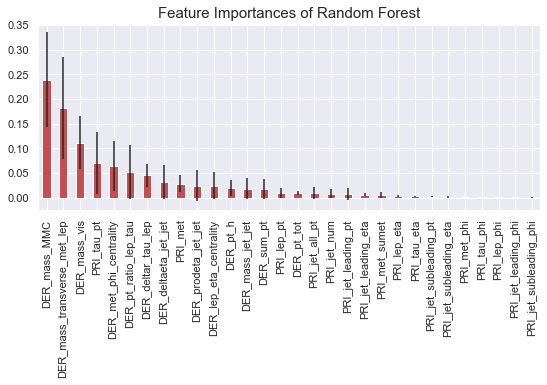

In [11]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)[indices]
# Print the feature ranking
print("Feature ranking:")
importances = pd.Series(clf.feature_importances_, index=data.columns)[indices]

# Plot the feature importances of the forest
plt.figure(figsize=(9,6))
plt.title("Feature Importances of Random Forest", fontsize=15)

importances.plot.bar(yerr=std, color='r')
plt.gcf().subplots_adjust(bottom=0.45)

#plt.savefig("figures/Feature_Importances.svg")

plt.show()

#ax.tick_params(axis='y', labelsize=10)
plt.show()